# 1. Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import itertools
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [2]:
from MFLUSolution import *

In [3]:
from selection_and_operators.mutation import swap_stages_slots_mutation, inversion_mutation, shuffle_mutation
from selection_and_operators.crossover import cycle_crossover, partially_matched_crossover, swap_time_slots_crossover
from selection_and_operators.selection import tournament_selection
from library.algorithm import *

In [4]:
from experiment import *

# 2. Genetic Algorithms

Baseline parameters:
- POP_SIZE = 50, 
- CROSSOVER_FUNCTION = cycle_crossover,
- MUTATION_FUNCTION = shuffle_mutation,
- NUMBER_OF_TESTS=30,
- MAX_GEN=100,
- S_RANKING_SELECTION=1.5,
- K_TOURNEMENT_SELECTION=5,
- SELECTION_ALGORITHM=tournament_selection,
- XO_PROB=0.9,
- MUT_PROB=0.4,
- MUT_MAX_WINDOW_SIZE=5, 
- ELITISM = True,
- VERBOSE = False

### 1st test - crossover and mutation operators:

Operators to test:

- Mutation: swap_slots_mutation, inversion_mutation, shuffle_mutation
- Crossover: cycle_crossover, partially_matched_crossover, swap_time_slots_crossover

In [ ]:
MAX_GEN=100
NUMBER_OF_TESTS=30

In [ ]:
grid_params = {
    "crossover": [
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.9
        },
        {
            "function": swap_time_slots_crossover,
            "xo_prob": 0.9
        }
    ],
    "mutation": [
        {
            "function": swap_stages_slots_mutation,
            "mut_prob": 0.6
        },
        {
            "function": inversion_mutation,
            "mut_prob": 0.25
        },

        {
            "function": shuffle_mutation,
            "mut_prob": 0.25
        }


    ],
    "elitism": [True, False]
}

In [18]:
all_results_test1=[] # list to store the results for all the experiments
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))
fitness_dfs = {}

for crossover_cfg, mutation_cfg, elitism in grid:

    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    experiment_name = f"{mutation_function.__name__}{mut_prob}__{crossover_function.__name__}{xo_prob}__{elitism}"
    print(f"\n\nRunning experiment: {experiment_name}")
    
    result = run_experiment_ga(
        EXPERIMENT_NAME=experiment_name,
        MUTATION_FUNCTION=mutation_function,
        CROSSOVER_FUNCTION=crossover_function,
        MUT_PROB=mut_prob,
        XO_PROB=xo_prob,
        MAX_GEN=MAX_GEN,
        NUMBER_OF_TESTS=NUMBER_OF_TESTS
    )
    all_results_test1.append(result)
    fitness_dfs[experiment_name] = result['df']




Running experiment: swap_stages_slots_mutation0.6__partially_matched_crossover0.8__True

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0.6981364631238374
Final best individual in generation 2: 0.6981364631238374
Final best individual in generation 3: 0.7133479335905134
Final best individual in generation 4: 0.7273786361835374
Final best individual in generation 5: 0.7411687170763215


Running experiment: swap_stages_slots_mutation0.6__partially_matched_crossover0.8__False

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0.6700272849611714
Final best individual in generation 2: 0.6935386832825222
Final best individual in generation 3: 0.6948675394922859
Final best individual in generation 4: 0.7087203533450998
Final best individual in generation 5: 0.7214742660990124


Running experiment: inversion_mutation0.2__partially_matched_crossover0.8__True

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0

In [22]:
fitness_dfs

{'swap_stages_slots_mutation0.6__partially_matched_crossover0.8__True':           0         1         2         3         4
 0  0.698136  0.698136  0.713348  0.727379  0.741169,
 'swap_stages_slots_mutation0.6__partially_matched_crossover0.8__False':           0         1         2        3         4
 0  0.670027  0.693539  0.694868  0.70872  0.721474,
 'inversion_mutation0.2__partially_matched_crossover0.8__True':           0         1         2         3         4
 0  0.681561  0.681561  0.709497  0.719772  0.720888,
 'inversion_mutation0.2__partially_matched_crossover0.8__False':           0         1         2         3         4
 0  0.734291  0.740522  0.740833  0.741767  0.751602,
 'shuffle_mutation0.2__partially_matched_crossover0.8__True':           0         1         2         3         4
 0  0.674152  0.688025  0.688025  0.709826  0.709826,
 'shuffle_mutation0.2__partially_matched_crossover0.8__False':           0         1         2         3         4
 0  0.681448  0.69686

In [ ]:
def plot_avg_median_fit_per_generation(results_dict):

    colors = [
        '#1f77b4', '#2ca02c', '#ff7f0e',
        '#9467bd', '#8c564b', '#17becf',
        '#e377c2', '#7f7f7f', '#bcbd22',
        '#aec7e8', '#98df8a', '#ffbb78'
    ]

    experiments = list(results_dict.keys())
    num_experiments = len(experiments)

    # Determinar o número máximo de gerações a partir dos dados
    any_df = list(results_dict.values())[0]
    MAX_GEN = any_df.shape[1] - 1  # última coluna = última geração (0-based)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for i, (exp_name, df) in enumerate(results_dict.items()):
        color = colors[i % len(colors)]
        label = f"{i+1}: {exp_name}"

        df_t = df.T

        avg = df_t.mean(axis=1)
        std = df_t.std(axis=1)
        med = df_t.median(axis=1)
        generations = df_t.index

        ax1.plot(generations, avg, label=label, color=color, linewidth=2)
        ax1.fill_between(generations, avg - std, avg + std, color=color, alpha=0.2)
        ax2.plot(generations, med, label=label, color=color, linewidth=2)

    for ax, title in zip((ax1, ax2), ("Average Fitness per Generation", "Median Fitness per Generation")):
        ax.set_title(title, fontsize=13, weight='bold')
        ax.set_xlabel("Generation")
        ax.set_xticks(range(0, MAX_GEN + 1, 20))
        ax.set_xlim(0, MAX_GEN)
        ax.grid(True, linestyle='--', alpha=0.5)

    ax1.set_ylabel("Fitness")

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=2, fontsize=8, frameon=False)

    plt.tight_layout()
    plt.show()


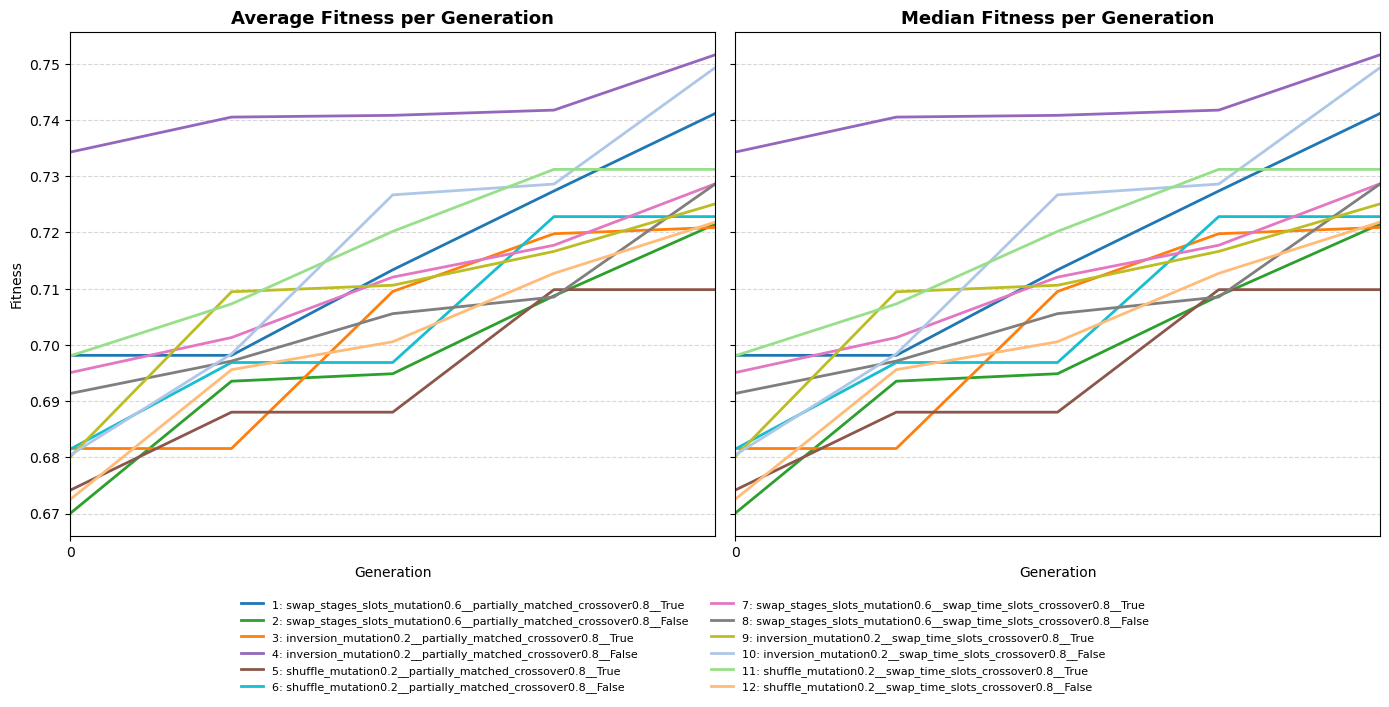

In [78]:
plot_avg_median_fit_per_generation(fitness_dfs)

In [65]:
def boxplots_final_fitness(results_input):
    import matplotlib.pyplot as plt

    operator_names = []
    final_fitness_by_experiment = []

    # Detecta se é um dict de DataFrames
    if isinstance(results_input, dict):
        for name, df in results_input.items():
            # Caso só haja 1 linha, não precisa de .T
            df_t = df if df.shape[0] > 1 else df.T
            final_fitness = df_t.iloc[:, -1].values
            final_fitness_by_experiment.append(final_fitness)
            operator_names.append(name)
    else:
        raise ValueError("This version only supports a dict of DataFrames like `fitness_dfs`.")

    # Boxplot
    plt.figure(figsize=(12, 6))
    positions = list(range(1, len(operator_names) + 1))
    box = plt.boxplot(final_fitness_by_experiment, patch_artist=True, positions=positions,
                      medianprops=dict(color='black'))


    plt.xticks(positions, labels=[str(i) for i in positions], fontsize=10)
    plt.xlabel("Experiment number", fontsize=12)
    plt.ylabel("Final Fitness", fontsize=12)
    plt.title("Final Fitness Distribution per Operator Combination", fontsize=14, weight='bold')


    legend_handles = [
        plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i}: {name}")
        for i, name in enumerate(operator_names, start=1)
    ]

    plt.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fontsize=9,
        ncol=2,              
        frameon=False
    )

    plt.tight_layout()
    plt.show()


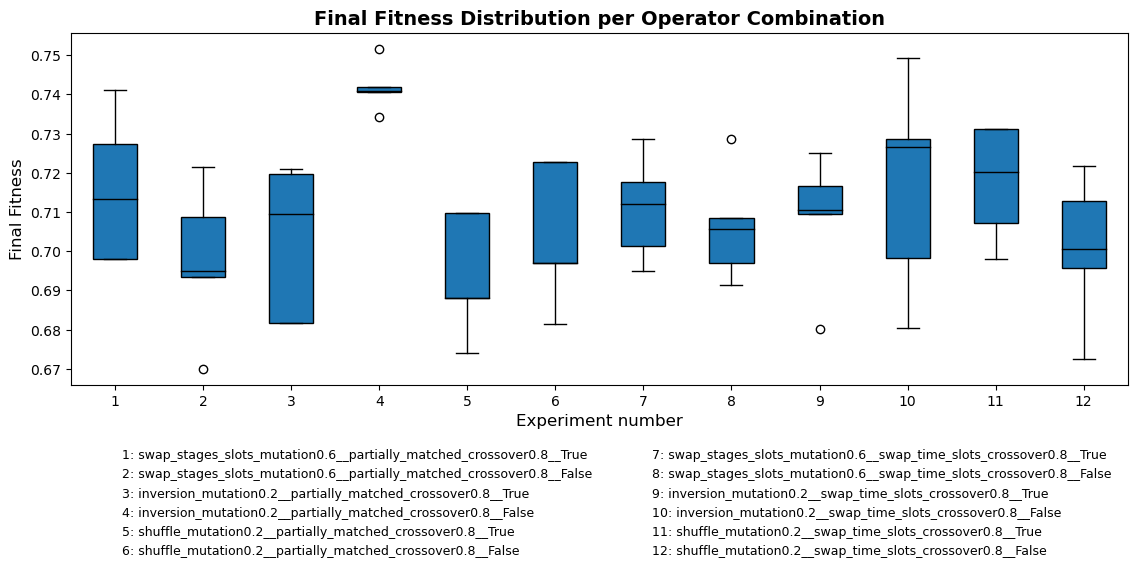

In [66]:
boxplots_final_fitness(fitness_dfs)

In [ ]:
def plot_mean_std_error(fitness_dfs):
    import matplotlib.pyplot as plt
    import numpy as np

    final_means = []
    final_stds = []
    operator_names = []

    for name, df in fitness_dfs.items():
        df_t = df if df.shape[0] > 1 else df.T  # garantir que execuções estão em linhas
        final_gen_values = df_t.iloc[:, -1].values  # última coluna (última geração)

        final_means.append(np.mean(final_gen_values))
        final_stds.append(np.std(final_gen_values, ddof=1))  # sample std dev
        operator_names.append(name)

    # Posições no eixo x
    x_pos = list(range(1, len(operator_names) + 1))

    plt.figure(figsize=(10, 6))
    for x, mean, std in zip(x_pos, final_means, final_stds):
        plt.errorbar(x, mean, yerr=std, fmt='o', capsize=5, markersize=6,
                     linestyle='None', color='tab:blue', linewidth=2)

    plt.xticks(x_pos, rotation=45, ha='right', fontsize=10)
    plt.ylabel("Fitness")
    plt.title("Final Generation Fitness: Mean ± Std Dev")

    legend_handles = [
        plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i}: {name}")
        for i, name in enumerate(operator_names, start=1)
    ]

    plt.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fontsize=9,
        ncol=2,              
        frameon=False
    )
    

    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


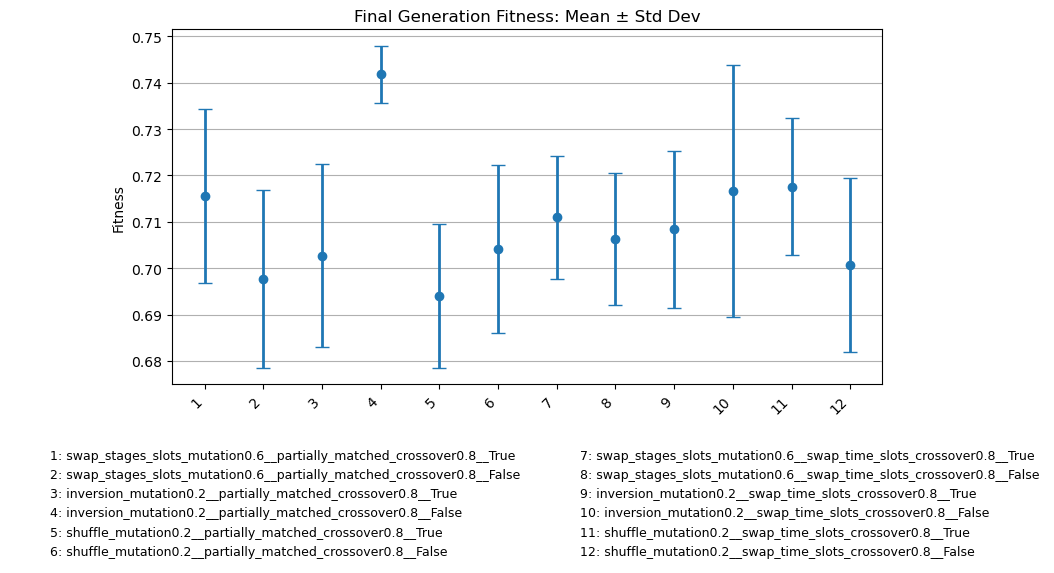

In [64]:
plot_mean_std_error(fitness_dfs)

In [50]:
def avg_elapsed_time_table(all_results):
    data = []
    for result in all_results:
        data.append({
            "Experience Name": result['name'],
            "Elapsed Time Avg": result['avg_elapsed_time']
        })
    avg_elapsed_time = pd.DataFrame(data)
    avg_elapsed_time.index = range(1, len(all_results)+1)
    return avg_elapsed_time

In [51]:
all_results_test1[0]['avg_elapsed_time']

23.632363319396973

In [52]:
avg_elapsed_time_table(all_results=all_results_test1)

,Experience Name,Elapsed Time Avg
1,swap_stages_slots_mutation0.6__partially_match...,23.632363
2,swap_stages_slots_mutation0.6__partially_match...,22.381992
3,inversion_mutation0.2__partially_matched_cross...,6.249457
4,inversion_mutation0.2__partially_matched_cross...,4.296139
5,shuffle_mutation0.2__partially_matched_crossov...,4.730948
6,shuffle_mutation0.2__partially_matched_crossov...,4.966199
7,swap_stages_slots_mutation0.6__swap_time_slots...,9.614562
8,swap_stages_slots_mutation0.6__swap_time_slots...,4.532710
9,inversion_mutation0.2__swap_time_slots_crossov...,4.361032
10,inversion_mutation0.2__swap_time_slots_crossov...,4.356040


In [ ]:
def plot_wilcoxon_heatmap_from_df_dict(fitness_dfs):
    # Step 1: Extrair fitness da última geração
    fitness_last_gen = {
        name: df.T.iloc[:, -1].values if df.shape[0] == 1 else df.iloc[:, -1].values
        for name, df in fitness_dfs.items()
    }

    # Step 2: DataFrame com scores e rankings médios
    df = pd.DataFrame(fitness_last_gen)
    avg_scores = df.mean()
    avg_ranks = df.rank(axis=1, method='average').mean()

    summary_df = pd.DataFrame({
        'Average Score (last gen)': avg_scores,
        'Average Rank': avg_ranks
    }).sort_values(by='Average Rank')

    # Step 3: Testes pareados (Wilcoxon) com correção de Holm
    names = list(fitness_last_gen.keys())
    p_values = []
    pairs = []

    for i, j in itertools.combinations(range(len(names)), 2):
        stat, p = wilcoxon(fitness_last_gen[names[i]], fitness_last_gen[names[j]])
        p_values.append(p)
        pairs.append((names[i], names[j]))

    _, p_vals_adj, _, _ = multipletests(p_values, method='holm')

    # Step 4: criar matriz de p-valores com etiquetas curtas
    short_labels = [str(i+1) for i in range(len(names))]
    name_to_label = dict(zip(names, short_labels))
    label_to_name = {v: k for k, v in name_to_label.items()}

    p_matrix_short = pd.DataFrame(
        np.ones((len(names), len(names))),
        index=short_labels,
        columns=short_labels
    )

    for (name_i, name_j), p in zip(pairs, p_vals_adj):
        i_label = name_to_label[name_i]
        j_label = name_to_label[name_j]
        p_matrix_short.loc[i_label, j_label] = p
        p_matrix_short.loc[j_label, i_label] = p

    # Step 5: Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        p_matrix_short,
        annot=True,
        fmt=".3f",
        cmap='PuOr',
        vmin=0,
        vmax=1,
        center=0.5,
        square=True,
        linewidths=0.5,
        cbar_kws={'label': 'Adjusted p-value'}
    )
    plt.title("Wilcoxon Signed-Rank Test (Final Generation Fitness)")
    plt.tight_layout()
    
    legend_handles = [
    plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i+1}: {names[i]}")
    for i in range(len(names))
    ]

    plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=9
    )

    plt.show()


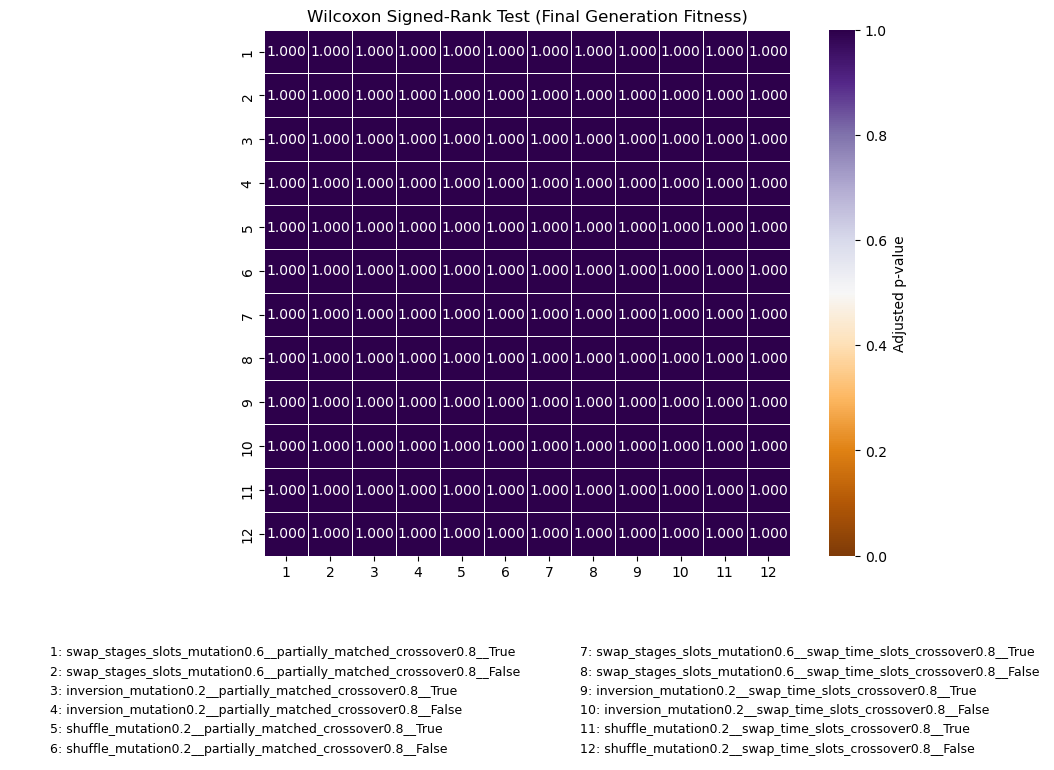

In [57]:
plot_wilcoxon_heatmap_from_df_dict(fitness_dfs)

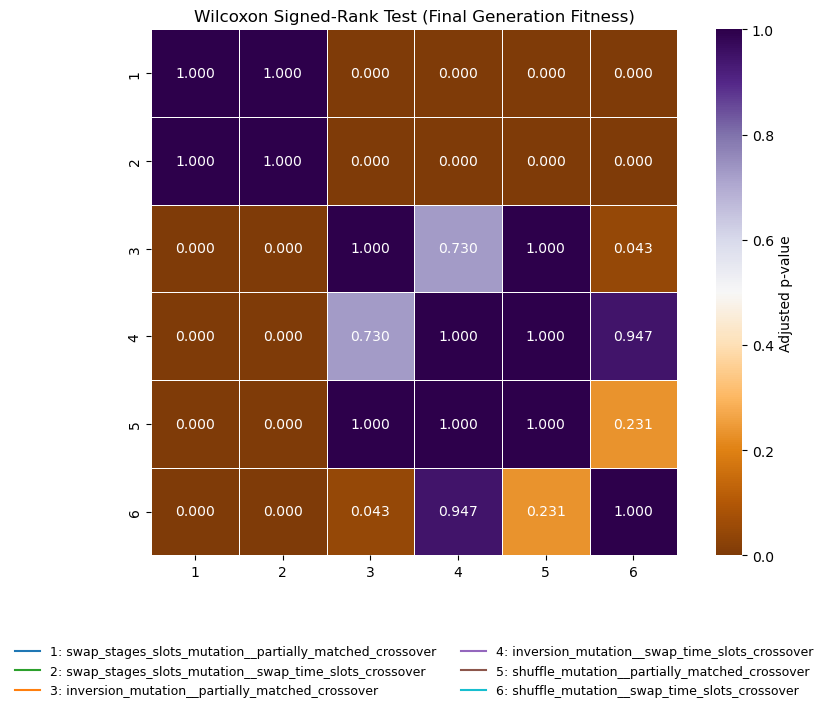

In [ ]:
import numpy as np
import pandas as pd
import itertools
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Step 1: Extract last-generation fitness for each experiment
fitness_last_gen = {
    res['name']: np.array(res['fitness_array'])[:, -1]
    for res in all_results_test1
}

# Step 2: Build DataFrame for summary (average score + rank)
df = pd.DataFrame(fitness_last_gen)
avg_scores = df.mean()
avg_ranks = df.rank(axis=1, method='average').mean()

summary_df = pd.DataFrame({
    'Average Score (last gen)': avg_scores,
    'Average Rank': avg_ranks
}).sort_values(by='Average Rank')

# Step 3: Pairwise Wilcoxon tests (Holm-adjusted)
names = list(fitness_last_gen.keys())
p_values = []
pairs = []

for i, j in itertools.combinations(range(len(names)), 2):
    stat, p = wilcoxon(fitness_last_gen[names[i]], fitness_last_gen[names[j]])
    p_values.append(p)
    pairs.append((names[i], names[j]))

_, p_vals_adj, _, _ = multipletests(p_values, method='holm')

# Custom short labels
short_labels = [str(i+1) for i in range(len(names))]
name_to_label = dict(zip(names, short_labels))
label_to_name = {v: k for k, v in name_to_label.items()}

# Create p-value matrix
p_matrix_short = pd.DataFrame(
    np.ones((len(names), len(names))),
    index=short_labels,
    columns=short_labels
)

for (name_i, name_j), p in zip(pairs, p_vals_adj):
    label_i = name_to_label[name_i]
    label_j = name_to_label[name_j]
    p_matrix_short.loc[label_i, label_j] = p
    p_matrix_short.loc[label_j, label_i] = p


# Step 4: Plot heatmap with short labels
plt.figure(figsize=(8, 6))
sns.heatmap(p_matrix_short, annot=True, fmt=".3f", cmap='PuOr',
            vmin=0, vmax=1, center=0.5,
            square=True, linewidths=0.5, cbar_kws={'label': 'Adjusted p-value'})
plt.title("Wilcoxon Signed-Rank Test (Final Generation Fitness)")
plt.tight_layout()

legend_handles = [
    plt.Line2D([0], [0], lw=1.5, label=f"{i+1}: {names[i]}")
    for i in range(len(names))
]
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=9
)

plt.show()


### Test crossover and mutation probabilities

In [ ]:
mutation_probabilities=[random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
crossover_probabilities =[random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
mut_funct=
xo_funct=

In [ ]:
all_results_test2=[]
for mut in mutation_probabilities:
    for xo in crossover_probabilities:
        experiment_name = f"mutation_prob:{mut}__crossover_prob{xo}"
        print(f"Running experiment: {experiment_name}")
        
        result = run_experiment_ga(
            EXPERIMENT_NAME=experiment_name,
            MUT_PORB=mut,
            XO_PROB=xo,
            MUTATION_FUNCTION=mut_funct,
            CROSSOVER_FUNCTION=xo_funct,
            MAX_GEN=40,
            NUMBER_OF_TESTS=2
        )

        all_results_test2.append(result)

In [ ]:
plot_avg_median_fit_per_generation(all_results=all_results_test2)

In [ ]:
boxplots_final_fitness(all_results=all_results_test2)

In [ ]:
plot_mean_std_error(all_results=all_results_test2)

In [ ]:
avg_elapsed_time_table(all_results=all_results_test2)

# 3. Hill Climbing

In [5]:
initial_solution_hc= LUHCSolution()

In [6]:
initial_solution_hc.fitness()

0.5448506567102158

In [7]:
best_sol=hill_climbing(initial_solution=initial_solution_hc, verbose=True, maximization=True)

Current solution: [11, 9, 26, 34, 21, 16, 28]
[0, 25, 12, 29, 14, 10, 33]
[24, 19, 32, 20, 7, 31, 8]
[17, 1, 4, 27, 18, 2, 5]
[3, 13, 6, 30, 23, 15, 22] with fitness 0.5448506567102158
Neighbor: [28, 11, 9, 26, 34, 21, 16]
[0, 25, 12, 29, 14, 10, 33]
[24, 19, 32, 20, 7, 31, 8]
[17, 1, 4, 27, 18, 2, 5]
[3, 13, 6, 30, 23, 15, 22] with fitness 0.5480662348816506
Neighbor: [11, 9, 26, 34, 21, 16, 28]
[33, 0, 25, 12, 29, 14, 10]
[24, 19, 32, 20, 7, 31, 8]
[17, 1, 4, 27, 18, 2, 5]
[3, 13, 6, 30, 23, 15, 22] with fitness 0.5580169999034097
Neighbor: [11, 9, 26, 34, 21, 16, 28]
[0, 25, 12, 29, 14, 10, 33]
[8, 24, 19, 32, 20, 7, 31]
[17, 1, 4, 27, 18, 2, 5]
[3, 13, 6, 30, 23, 15, 22] with fitness 0.5250529480084717
Neighbor: [11, 9, 26, 34, 21, 16, 28]
[0, 25, 12, 29, 14, 10, 33]
[24, 19, 32, 20, 7, 31, 8]
[5, 17, 1, 4, 27, 18, 2]
[3, 13, 6, 30, 23, 15, 22] with fitness 0.5115426777051946
Neighbor: [11, 9, 26, 34, 21, 16, 28]
[0, 25, 12, 29, 14, 10, 33]
[24, 19, 32, 20, 7, 31, 8]
[17, 1, 4, 27,

In [8]:
best_sol

([[16, 28, 11, 9, 26, 34, 21], [14, 10, 33, 0, 25, 12, 29], [31, 8, 24, 19, 32, 20, 7], [17, 1, 4, 27, 18, 2, 5], [3, 13, 6, 30, 23, 15, 22]],
 [0.5580169999034097,
  0.5984516623085329,
  0.6400147636126842,
  0.646600523894581,
  0.6665219756034791,
  0.6792303680092727,
  0.6961618503200654,
  0.6961618503200654])

In [9]:
MAX_ITER=[1, 2]
NUMBER_OF_TESTS=2

In [10]:
all_results_hc=[]
for iter in MAX_ITER:
    result=run_experiment_hc(
    EXPERIMENT_NAME = f"hc_iter_{iter}",
    NUMBER_OF_TESTS=NUMBER_OF_TESTS,
    MAX_GEN=MAX_ITER,
    VERBOSE=True)
    all_results_hc.append(result)
        

Iteration 0 of the HC algorithm

Current solution: [27, 29, 24, 30, 26, 18, 10]
[9, 8, 17, 3, 22, 11, 0]
[2, 6, 32, 15, 20, 25, 16]
[23, 34, 13, 1, 14, 5, 21]
[28, 31, 19, 4, 33, 7, 12] with fitness 0.5954666924240961
Neighbor: [10, 27, 29, 24, 30, 26, 18]
[9, 8, 17, 3, 22, 11, 0]
[2, 6, 32, 15, 20, 25, 16]
[23, 34, 13, 1, 14, 5, 21]
[28, 31, 19, 4, 33, 7, 12] with fitness 0.6045248193321217
Neighbor: [27, 29, 24, 30, 26, 18, 10]
[0, 9, 8, 17, 3, 22, 11]
[2, 6, 32, 15, 20, 25, 16]
[23, 34, 13, 1, 14, 5, 21]
[28, 31, 19, 4, 33, 7, 12] with fitness 0.5811807425521373
Neighbor: [27, 29, 24, 30, 26, 18, 10]
[9, 8, 17, 3, 22, 11, 0]
[16, 2, 6, 32, 15, 20, 25]
[23, 34, 13, 1, 14, 5, 21]
[28, 31, 19, 4, 33, 7, 12] with fitness 0.6089710154618877
Neighbor: [27, 29, 24, 30, 26, 18, 10]
[9, 8, 17, 3, 22, 11, 0]
[2, 6, 32, 15, 20, 25, 16]
[21, 23, 34, 13, 1, 14, 5]
[28, 31, 19, 4, 33, 7, 12] with fitness 0.5790823915773207
Neighbor: [27, 29, 24, 30, 26, 18, 10]
[9, 8, 17, 3, 22, 11, 0]
[2, 6, 32,

In [11]:
plot_avg_median_fit_per_generation(all_results=all_results_hc)

KeyError: 'stats_df'

ValueError: List of boxplot statistics and `positions` values must have same the length

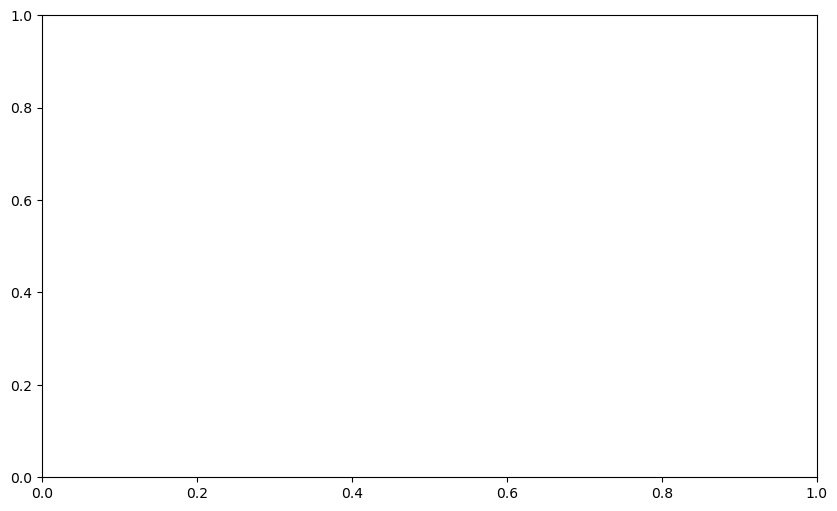

In [23]:
boxplots_final_fitness(all_results=all_results_hc)

# 4. Simulated Annealing

In [5]:
initial_solution_sa=LUSASolution()

In [6]:
MAX_ITER=2
NUMBER_OF_TESTS=2
C=[2, 2.5]
L=20
H=10

In [8]:
all_results_sa=[]
for c in C:
    result=run_experiment_sa(
    EXPERIMENT_NAME = f"sa_iter_{c}",
    NUMBER_OF_TESTS=NUMBER_OF_TESTS,
    MAX_GEN=MAX_ITER,
    C=c,
    L=L,
    H=H,
    VERBOSE=True)
    all_results_sa.append(result)

Iteration 0 of the SA algorithm

Initial solution: [[1, 17, 12, 4, 28, 32, 8], [34, 18, 21, 26, 16, 11, 29], [0, 31, 22, 7, 6, 13, 5], [20, 14, 23, 2, 33, 19, 24], [30, 27, 25, 15, 3, 10, 9]] with fitness 0.5922487221489581
Random neighbor [1, 17, 12, 4, 28, 32, 8]
[34, 18, 21, 26, 11, 16, 29]
[0, 31, 22, 7, 6, 13, 5]
[20, 14, 23, 2, 33, 19, 24]
[30, 27, 25, 15, 3, 10, 9] with fitness: 0.6085752527612031
Neighbor is better. Replaced current solution by neighbor.
New current solution [1, 17, 12, 4, 28, 32, 8]
[34, 18, 21, 26, 11, 16, 29]
[0, 31, 22, 7, 6, 13, 5]
[20, 14, 23, 2, 33, 19, 24]
[30, 27, 25, 15, 3, 10, 9] with fitness 0.6085752527612031
Random neighbor [1, 17, 12, 4, 28, 32, 8]
[34, 18, 26, 21, 11, 16, 29]
[0, 31, 22, 7, 6, 13, 5]
[20, 14, 23, 2, 33, 19, 24]
[30, 27, 25, 15, 3, 10, 9] with fitness: 0.5864327693942298
Probability of accepting worse neighbor: 0.9889898189659065
Neighbor is worse and was accepted.
New current solution [1, 17, 12, 4, 28, 32, 8]
[34, 18, 26, 21, 1

Neighbor is better. Replaced current solution by neighbor.
New current solution [1, 17, 4, 12, 28, 8, 32]
[34, 26, 18, 11, 21, 16, 29]
[31, 13, 0, 7, 22, 6, 20]
[5, 19, 23, 2, 33, 14, 30]
[24, 27, 25, 15, 3, 10, 9] with fitness 0.5803695365561491
Random neighbor [1, 17, 4, 12, 28, 8, 32]
[34, 26, 18, 11, 21, 29, 16]
[31, 13, 0, 7, 22, 6, 20]
[5, 19, 23, 2, 33, 14, 30]
[24, 27, 25, 15, 3, 10, 9] with fitness: 0.5661641491256096
Probability of accepting worse neighbor: 0.9314368015343083
Neighbor is worse and was accepted.
New current solution [1, 17, 4, 12, 28, 8, 32]
[34, 26, 18, 11, 21, 29, 16]
[31, 13, 0, 7, 22, 6, 20]
[5, 19, 23, 2, 33, 14, 30]
[24, 27, 25, 15, 3, 10, 9] with fitness 0.5661641491256096
Random neighbor [1, 17, 4, 12, 28, 8, 32]
[34, 26, 18, 11, 21, 29, 16]
[31, 13, 0, 7, 22, 6, 20]
[5, 19, 23, 2, 33, 14, 30]
[24, 27, 25, 15, 10, 3, 9] with fitness: 0.5726761556376161
Neighbor is better. Replaced current solution by neighbor.
New current solution [1, 17, 4, 12, 28, 8,

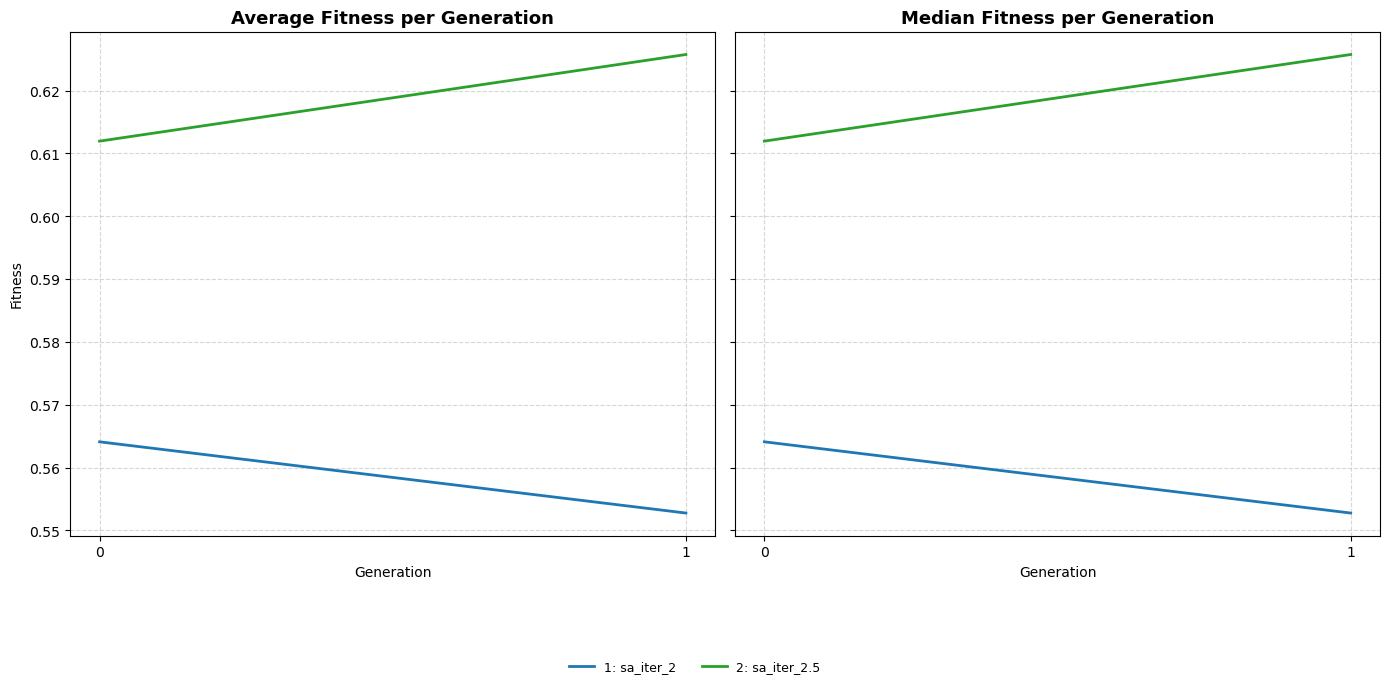

In [9]:
plot_avg_median_fit_per_generation(all_results=all_results_sa)

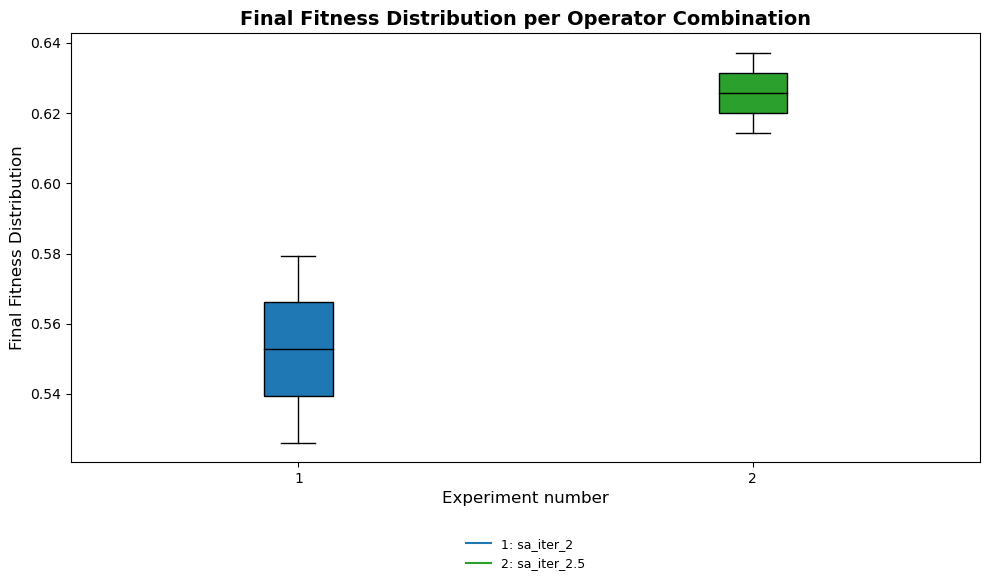

In [11]:
boxplots_final_fitness(all_results=all_results_sa)

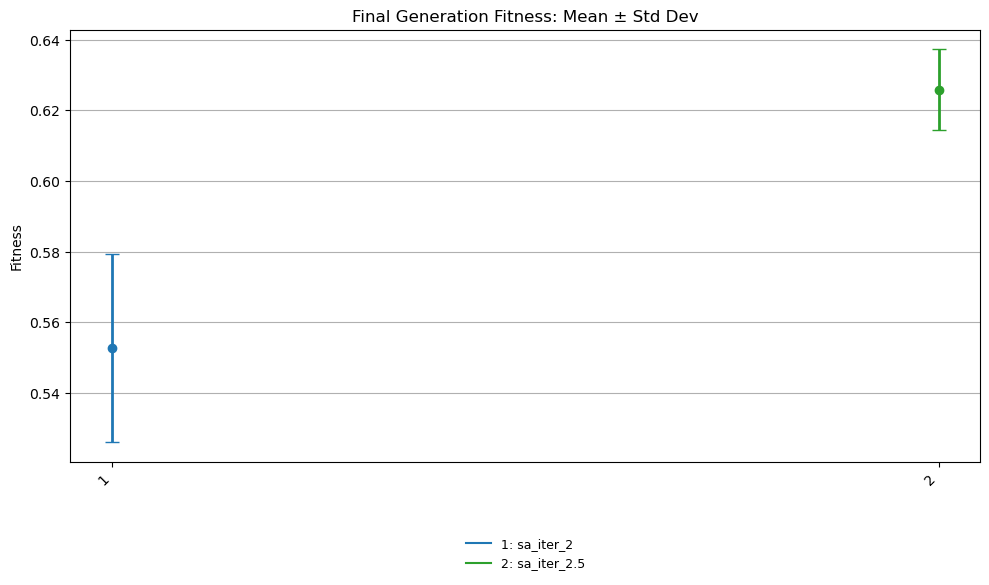

In [13]:
plot_mean_std_error(all_results=all_results_sa)

In [14]:
avg_elapsed_time_table(all_results=all_results_sa)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 6 elements

In [6]:
solution=LUSASolution()

In [7]:
solution.get_random_neighbor()

initial: [[7, 24, 3, 20, 34, 12, 2], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [32, 14, 16, 22, 23, 11, 31]]
neighbor: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [32, 14, 16, 22, 23, 11, 31]]


[[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [32, 14, 16, 22, 23, 11, 31]]

In [27]:
solution_best=simulated_annealing(initial_solution=solution, C=4, L=20, H=30)

initial: [[7, 24, 3, 20, 34, 12, 2], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [32, 14, 16, 22, 23, 11, 31]]
neighbor: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [32, 14, 16, 22, 23, 11, 31]]
initial: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [32, 14, 16, 22, 23, 11, 31]]
neighbor: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [31, 32, 14, 16, 22, 23, 11]]
initial: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [31, 32, 14, 16, 22, 23, 11]]
neighbor: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 18, 6, 10, 26, 33, 5], [11, 31, 32, 14, 16, 22, 23]]
initial: [[2, 7, 24, 3, 20, 34, 12], [27, 30, 15, 1, 28, 8, 21], [9, 13, 29, 19, 25, 4, 17], [0, 

In [28]:
solution_best

([[2, 7, 24, 3, 20, 34, 12], [15, 1, 28, 8, 21, 27, 30], [13, 29, 19, 25, 4, 17, 9], [33, 5, 0, 18, 6, 10, 26], [23, 11, 31, 32, 14, 16, 22]],
 [0.605706276763579,
  0.5232091775702323,
  0.6438814897412478,
  0.6438814897412478,
  0.6438814897412478,
  0.6438814897412478,
  0.6438814897412478,
  0.6438814897412478,
  0.6438814897412478,
  0.6438814897412478])

In [33]:
initial_solution_sa_kap=LUKAPSASolution()
best_solution=simulated_annealing(initial_solution=initial_solution_sa_kap, C=2.5, H=50, L=50, max_iter=20)

In [34]:
best_solution

([[0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0]],
 [0.6005129853665605,
  0.5702152320943051,
  0.6504367720299862,
  0.6504367720299862,
  0.6504367720299862,
  0.6504367720299862,
  0.6504367720299862,
  0.6504367720299862,
  0.650436772029

# 5. Compare GA with SA